In [2]:
import json
import pandas as pd
from pathlib import Path
import numpy as np

In [3]:
folder_path = 'E:/work/data/waze-trafmine/2018/4'

In [4]:
def from_json_folder_to_json_docs(folder_path):
    pathlist = Path(folder_path).glob('**/*.json')
    json_docs = []
    for path in pathlist:
        # because path is object not string
        path_in_str = str(path)
        print('processing file: ' + path_in_str)
        with open(path_in_str, encoding="utf8") as f:
            json_file = json.load(f)
            json_docs.append(json_file)
    print('Done!')
    return json_docs

In [5]:
json_data = from_json_folder_to_json_docs(folder_path)

processing file: E:\work\data\waze-trafmine\2018\4\1-10.json
processing file: E:\work\data\waze-trafmine\2018\4\11-20.json
processing file: E:\work\data\waze-trafmine\2018\4\21-30.json
Done!


In [6]:
first_it = True
for json in json_data:
    #print(json.keys())
    if first_it != True:
        alerts_df.append(pd.DataFrame(json['alerts']), ignore_index=True)
        jams_df.append(pd.DataFrame(json['jams']), ignore_index=True)
    else:
        alerts_df = pd.DataFrame(json['alerts'])
        jams_df = pd.DataFrame(json['jams'])
        first_it = False

In [7]:
alerts_df.head(3)

,uuid,alert_type_id,alert_subtype_id,country,report_rating,confidence,reliability,magvar,location,publish_date,last_seen,city,road_type,street,report_description,thumbs_up,report_by_partner,jam_uuid
0,8271e6bf-fca0-3cad-bac4-6a6959d16b1c,4,13.0,CI,0,5,10,265,"[-70.646227, -33.635035]",2018-04-01T01:02:02+00:00,2018-04-01T03:00:21+00:00,None,3.0,Ruta 79,None,0,None,None
1,e7b8841f-a144-3b7d-b685-05bc447b73fd,3,4.0,CI,1,0,5,56,"[-70.670608, -33.398605]",2018-04-01T02:30:58+00:00,2018-04-01T03:00:21+00:00,Conchalí,2.0,Av. Dorsal,None,0,None,None
2,e1c149d5-4383-3490-bb2d-550156e3ad51,3,3.0,CI,1,0,5,2,"[-70.575705, -33.469535]",2018-04-01T02:31:00+00:00,2018-04-01T03:00:21+00:00,Ñuñoa,2.0,None,None,0,None,None


In [8]:
alerts_df.shape

(115547, 18)

In [9]:
# parse date to datetime object
alerts_df['publish_date_dt'] = pd.to_datetime(alerts_df['publish_date'])

In [10]:
# subsets dataframe
alerts_df.drop(alerts_df.columns.difference(['alert_subtype_id', 'alert_type_id', 'street', 'publish_date_dt']), 1, inplace=True)

In [11]:
# drop duplicates
alerts_df.drop_duplicates(inplace=True)

In [12]:
# drop nans from alert_subtype_id, street
alerts_df.dropna(subset=['alert_subtype_id','street'], inplace=True)

In [13]:
# sort by date just in case
alerts_df.sort_values(by=['publish_date_dt'], inplace = True)

In [14]:
# set date as index, not sure if good idea
#alerts_df = alerts_df.set_index('publish_date_dt').sort_index()

In [15]:
alerts_df.head(3)

,alert_type_id,alert_subtype_id,street,publish_date_dt
115496,4,7.0,Alberto Llona,2016-08-06 17:55:23+00:00
115542,4,7.0,Manuel Antonio Matta,2017-01-14 15:01:37+00:00
115497,4,7.0,Manuel Antonio Matta,2017-01-14 16:01:37+00:00


In [16]:
alerts_df.shape

(106885, 4)

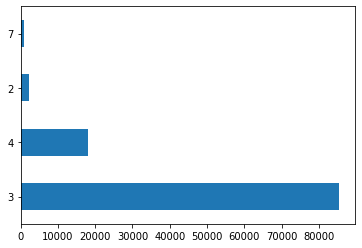

In [19]:
alerts_df['alert_type_id'].value_counts().plot(kind='barh')

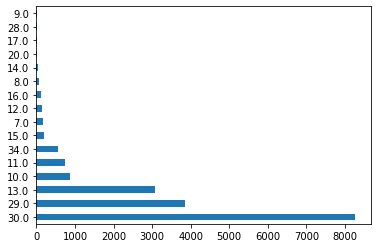

In [18]:
alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 4].value_counts().plot(kind='barh')

In [20]:
print(np.sort(alerts_df['alert_subtype_id'].unique()))

[ 1.  2.  3.  4.  5.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 20. 28.
 29. 30. 31. 32. 33. 34.]


In [21]:
print(np.sort(alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 2].unique()))

[1. 2.]


In [22]:
print(np.sort(alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 3].unique()))

[3. 4. 5.]


In [23]:
print(np.sort(alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 4].unique()))

[ 7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 20. 28. 29. 30. 34.]


In [24]:
print(np.sort(alerts_df['alert_subtype_id'][alerts_df['alert_type_id'] == 7].unique()))

[31. 32. 33.]


I have to assume that 'alert_type_id' is 3 (JAM) and 'alert_subtype_id' 4 is JAM_HEAVY_TRAFFIC and 5 is JAM_STAND_STILL_TRAFFIC

In [25]:
alerts_df['street'].unique().shape

(3140,)

In [26]:
# res_df = alerts_df[:200].apply(lambda row: list(alerts_df['alert_subtype_id'][(alerts_df['street'] == row['street']) & 
#                                                                (alerts_df['publish_date_dt'] <= row['publish_date_dt']) & 
#                                                                (alerts_df['publish_date_dt'] >= row['publish_date_dt'] - pd.Timedelta(minutes=30))])
#                , axis = 1)

In [28]:
import dask.dataframe as dd
from dask.multiprocessing import get
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4, threads_per_worker=2)
client = Client(cluster, asynchronous=True,
                memory_limit='10GB')

ddata = dd.from_pandas(alerts_df, npartitions=36)

alerts_df['seq'] = ddata.map_partitions(lambda df: df.apply((lambda row: list(alerts_df['alert_subtype_id'][(alerts_df['street'] == row['street']) & 
                                                               (alerts_df['publish_date_dt'] < row['publish_date_dt']) & 
                                                               (alerts_df['publish_date_dt'] >= row['publish_date_dt'] - pd.Timedelta('00:30:00'))]))
                                                , axis=1)).compute(scheduler=client)

In [29]:
alerts_df.head()

,alert_type_id,alert_subtype_id,street,publish_date_dt,seq
115496,4,7.0,Alberto Llona,2016-08-06 17:55:23+00:00,[]
115542,4,7.0,Manuel Antonio Matta,2017-01-14 15:01:37+00:00,[]
115497,4,7.0,Manuel Antonio Matta,2017-01-14 16:01:37+00:00,[]
115543,4,7.0,Av. Independencia,2017-02-14 12:40:23+00:00,[]
115498,4,7.0,Av. Independencia,2017-02-14 13:40:23+00:00,[]


In [30]:
alerts_df_w_seq = alerts_df[alerts_df.astype(str)['seq'] != '[]'].copy()

In [31]:
alerts_df_w_seq.head()

,alert_type_id,alert_subtype_id,street,publish_date_dt,seq
115494,7,33.0,Av. O'Higgins,2018-02-22 18:55:16+00:00,[33.0]
115508,7,33.0,Av. O'Higgins,2018-02-22 18:55:17+00:00,"[33.0, 33.0]"
115495,7,33.0,Av. O'Higgins,2018-02-22 18:55:18+00:00,"[33.0, 33.0, 33.0]"
115478,7,33.0,Carlos Silva Vildósola,2018-03-05 15:37:45+00:00,[33.0]
27,4,7.0,Autopista Central,2018-04-01 02:54:35+00:00,[3.0]


In [32]:
alerts_df_w_seq.shape

(72528, 5)

In [33]:
alerts_df[(alerts_df['alert_type_id'] == 3) &
          ((alerts_df['alert_subtype_id'] == 4) | (alerts_df['alert_subtype_id'] == 5)) & 
          (alerts_df.astype(str)['seq'] != '[]')].head()

,alert_type_id,alert_subtype_id,street,publish_date_dt,seq
60,3,4.0,Antonia López de Bello,2018-04-01 04:07:34+00:00,[4.0]
78,3,5.0,Antonia López de Bello,2018-04-01 04:56:23+00:00,[4.0]
177,3,5.0,Boulevard Lyon Juana de Arco,2018-04-01 12:06:15+00:00,[30.0]
268,3,4.0,Ruta 78 / Autopista del Sol,2018-04-01 14:10:44+00:00,"[13.0, 13.0, 13.0, 13.0]"
278,3,4.0,Av. Camilo Henríquez,2018-04-01 14:23:36+00:00,[4.0]


In [34]:
alerts_df[(alerts_df['alert_type_id'] == 3) &
          ((alerts_df['alert_subtype_id'] == 4) | (alerts_df['alert_subtype_id'] == 5)) & 
          (alerts_df.astype(str)['seq'] != '[]')].shape

(50779, 5)

In [35]:
alerts_df_w_seq['label'] = np.where((alerts_df_w_seq['alert_type_id'] == 3) &
                                    ((alerts_df_w_seq['alert_subtype_id'] == 4) | (alerts_df_w_seq['alert_subtype_id'] == 5)) &
                                    (alerts_df_w_seq.astype(str)['seq'] != '[]'), 1, 0)

In [36]:
alerts_df_w_seq[alerts_df_w_seq['label'] == 0].head(3)

,alert_type_id,alert_subtype_id,street,publish_date_dt,seq,label
115494,7,33.0,Av. O'Higgins,2018-02-22 18:55:16+00:00,[33.0],0
115508,7,33.0,Av. O'Higgins,2018-02-22 18:55:17+00:00,"[33.0, 33.0]",0
115495,7,33.0,Av. O'Higgins,2018-02-22 18:55:18+00:00,"[33.0, 33.0, 33.0]",0


In [37]:
alerts_df_w_seq[alerts_df_w_seq['label'] == 0].shape

(21749, 6)

In [38]:
alerts_df_w_seq[alerts_df_w_seq['label'] == 1].head(3)

,alert_type_id,alert_subtype_id,street,publish_date_dt,seq,label
60,3,4.0,Antonia López de Bello,2018-04-01 04:07:34+00:00,[4.0],1
78,3,5.0,Antonia López de Bello,2018-04-01 04:56:23+00:00,[4.0],1
177,3,5.0,Boulevard Lyon Juana de Arco,2018-04-01 12:06:15+00:00,[30.0],1


In [39]:
alerts_df_w_seq[alerts_df_w_seq['label'] == 1].shape

(50779, 6)

In [40]:
max_len_event_id = alerts_df_w_seq.seq.apply(len).idxmax()
max_len_event_id

91217

In [41]:
max_len_event = alerts_df_w_seq.loc[max_len_event_id]
print(max_len_event.seq)

[1.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 5.0, 4.0, 4.0, 5.0, 5.0, 30.0, 1.0, 30.0, 3.0, 3.0, 5.0, 30.0, 5.0, 4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 30.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 5.0, 3.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 4.0, 4.0, 3.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 13.0, 4.0, 5.0, 4.0, 5.0, 5.0, 13.0, 5.0, 4.0, 4.0, 4.0, 4.0, 4.0]


In [42]:
maxlen = len(max_len_event.seq)
maxlen

90

In [43]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [44]:
sequences = alerts_df_w_seq.seq.tolist()
sequences[:5]

[[33.0], [33.0, 33.0], [33.0, 33.0, 33.0], [33.0], [3.0]]

In [45]:
data = pad_sequences(sequences, maxlen=maxlen)
data

array([[ 0,  0,  0, ...,  0,  0, 33],
       [ 0,  0,  0, ...,  0, 33, 33],
       [ 0,  0,  0, ..., 33, 33, 33],
       ...,
       [ 0,  0,  0, ...,  0,  0, 29],
       [ 0,  0,  0, ...,  0, 29, 29],
       [ 0,  0,  0, ..., 29, 29, 10]])

In [46]:
labels = np.array(alerts_df_w_seq.label)

In [47]:
np.random.seed(12)

In [48]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [49]:
training_samples = int(len(indices) * .8)
validation_samples = len(indices) - training_samples

In [50]:
X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples: training_samples + validation_samples]
y_valid = labels[training_samples: training_samples + validation_samples]

In [51]:
X_train

array([[ 0,  0,  0, ..., 30,  1,  3],
       [ 0,  0,  0, ...,  0,  0,  4],
       [ 0,  0,  0, ...,  4,  5,  4],
       ...,
       [ 0,  0,  0, ...,  0,  4,  5],
       [ 0,  0,  0, ..., 30,  3,  5],
       [ 0,  0,  0, ...,  4,  4,  5]])

In [52]:
num_events = 34 + 1
num_events

35

In [53]:
embedding_dim = 20

In [54]:
embedding_matrix = np.random.rand(num_events, embedding_dim)

To check for gpu run the folowing in terminal:

python

import tensorflow as tf

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [55]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM

units = 34

model = Sequential()
model.add(Embedding(num_events, embedding_dim))
model.add(LSTM(units))
model.add(Dense(1, activation='sigmoid'))

W0819 12:26:50.231582 15448 deprecation_wrapper.py:119] From C:\Users\nvillalobos\AppData\Local\Continuum\miniconda3\envs\keras_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 12:26:50.233536 15448 deprecation_wrapper.py:119] From C:\Users\nvillalobos\AppData\Local\Continuum\miniconda3\envs\keras_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 12:26:50.237567 15448 deprecation_wrapper.py:119] From C:\Users\nvillalobos\AppData\Local\Continuum\miniconda3\envs\keras_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [56]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

W0819 12:27:31.326599 15448 deprecation_wrapper.py:119] From C:\Users\nvillalobos\AppData\Local\Continuum\miniconda3\envs\keras_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0819 12:27:31.327577 15448 deprecation_wrapper.py:119] From C:\Users\nvillalobos\AppData\Local\Continuum\miniconda3\envs\keras_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [57]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=3,
                    batch_size=32,
                    validation_data=(X_valid, y_valid))
model.save("mymodel_embedding_untrainable.h5")

W0819 12:28:09.380060 15448 deprecation_wrapper.py:119] From C:\Users\nvillalobos\AppData\Local\Continuum\miniconda3\envs\keras_cpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0819 12:28:09.405061 15448 deprecation.py:323] From C:\Users\nvillalobos\AppData\Local\Continuum\miniconda3\envs\keras_cpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 58022 samples, validate on 14506 samples
Epoch 1/3
58022/58022 [==============================] - 78s 1ms/step - loss: 0.5611 - acc: 0.7285 - val_loss: 0.5595 - val_acc: 0.7331
Epoch 2/3
58022/58022 [==============================] - 92s 2ms/step - loss: 0.5503 - acc: 0.7379 - val_loss: 0.5562 - val_acc: 0.7301
Epoch 3/3
58022/58022 [==============================] - 93s 2ms/step - loss: 0.5484 - acc: 0.7390 - val_loss: 0.5528 - val_acc: 0.7354


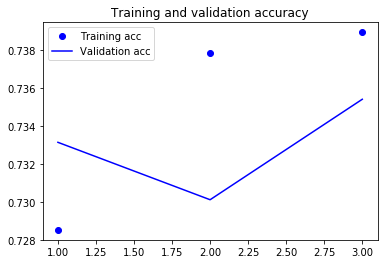

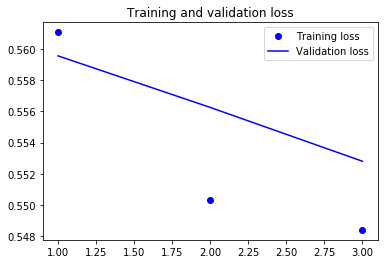

In [58]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

So next step, we can do an experiment to allow the Embedding layer be trained and adjusted.

In [59]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM

units = 32

model = Sequential()
model.add(Embedding(num_events, embedding_dim))
model.add(LSTM(units))
model.add(Dense(1, activation='sigmoid'))

In [60]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [61]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=3,
                    batch_size=32,
                    validation_data=(X_valid, y_valid))
model.save("mymodel_embedding_trainable.h5")

Train on 58022 samples, validate on 14506 samples
Epoch 1/3
58022/58022 [==============================] - 78s 1ms/step - loss: 0.5557 - acc: 0.7336 - val_loss: 0.5565 - val_acc: 0.7356
Epoch 2/3
58022/58022 [==============================] - 82s 1ms/step - loss: 0.5469 - acc: 0.7407 - val_loss: 0.5537 - val_acc: 0.7360
Epoch 3/3
58022/58022 [==============================] - 90s 2ms/step - loss: 0.5457 - acc: 0.7420 - val_loss: 0.5523 - val_acc: 0.7363


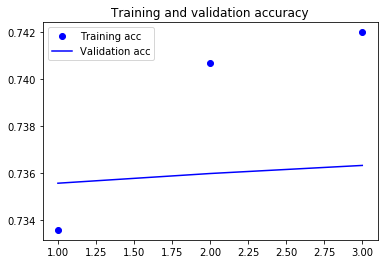

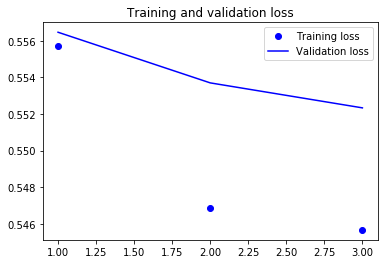

In [62]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()